# solving job shop scheduling problem with GA

- la40  
http://jobshop.jjvh.nl/

https://github.com/Eason0227/Job-shop-scheduling-problem/blob/main/GA%20for%20JSSP.ipynb


In [16]:
import pandas as pd
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# import plotly.plotly as py
# # from chart_studio import plotly as py
from plotly.offline import iplot

import plotly.figure_factory as ff
import datetime

%matplotlib inline

# 100 個の int 型要素を持つ配列
Chromosome = list[int]


In [2]:
!pwd

/working_dir/notebooks


In [20]:
processing_df= pd.read_csv("data/jssp/Processing_time.csv")
sequence_df = pd.read_csv("data/jssp/Machine_sequence.csv")

processing_df = processing_df.drop(["Job"],axis=1)
sequence_df = sequence_df.drop(["Job"],axis=1)

num_machine = processing_df.shape[0]  # number of machines
num_job = processing_df.shape[1]  # number of jobs
num_gene = num_machine * num_job  # number of genes in a chromosome

# processing_times
pt = [list(map(int, processing_df.iloc[i])) for i in range(num_job)]
#　machine_sequences for tasks
ms = [list(map(int, sequence_df.iloc[i])) for i in range(num_job)]


In [19]:
pt

[[82, 14, 15, 4, 95, 36, 32, 29, 18, 95],
 [88, 21, 83, 10, 78, 82, 22, 69, 94, 32],
 [87, 28, 95, 70, 12, 76, 55, 5, 4, 12],
 [30, 70, 65, 78, 4, 72, 26, 92, 84, 90],
 [54, 55, 29, 58, 76, 36, 1, 98, 21, 90],
 [44, 13, 36, 20, 28, 98, 44, 14, 12, 49],
 [46, 49, 45, 78, 34, 6, 94, 59, 69, 16],
 [11, 9, 71, 38, 81, 80, 47, 74, 25, 91],
 [6, 36, 85, 30, 99, 38, 11, 30, 13, 49],
 [59, 90, 82, 47, 21, 48, 46, 27, 86, 35]]

In [4]:
tmp = np.random.permutation(num_gene) % num_job
# pd.Series(tmp).value_counts()
tmp

array([2, 9, 3, 7, 0, 5, 1, 5, 8, 5, 5, 3, 0, 7, 7, 0, 5, 6, 4, 9, 2, 8,
       8, 9, 3, 1, 6, 9, 3, 9, 6, 5, 7, 7, 4, 2, 0, 4, 9, 3, 2, 8, 4, 1,
       5, 1, 8, 9, 4, 8, 0, 4, 1, 5, 4, 0, 7, 1, 5, 4, 1, 7, 1, 6, 0, 6,
       2, 8, 3, 2, 4, 6, 2, 8, 8, 4, 3, 9, 3, 1, 0, 8, 0, 0, 6, 7, 9, 2,
       6, 7, 1, 6, 9, 3, 2, 3, 6, 2, 5, 7])

In [31]:
def inital_population(population_size: int):
    """
    初期の1世代分の個体を生成する
    """
    population_list: list = []
    for i in range(population_size):
        # generate a random permutation of 0 to num_job * num_mc - 1
        ini_pop: list = list(np.random.permutation(num_gene) % num_job)

        # convert to job number format, every job appears m(num_job) times
        population_list.append(ini_pop)
    return population_list


def crossover(population_list: list, crossover_rate: float):
    """
    2点交叉を行う
    """
    parent_list: list = population_list.copy() # preserve the original parent chromosomes
    offspring_list: list = population_list.copy()

    # 產生一個組合去選擇用哪幾組父代染色體進行交配
    # 組み合わせを生成して、交配に使用する親染色体のセットを選択します
    parent_sequence = list(np.random.permutation(population_size))
    for i in range(0, population_size, step=2):
        crossover_prob=np.random.rand()
        if crossover_prob <= crossover_rate:
            parent_1 = population_list[ parent_sequence[i] ][:]
            parent_2 = population_list[ parent_sequence[i + 1] ][:]
            child_1 = parent_1[:]
            child_2 = parent_2[:]
            # 產生2個不同的交配點，並由小到大排序
            # 2つの異なる交点を生成し、小さいものから大きいものに並べ替えます。
            crossover_point = list( np.random.choice(num_gene, 2, replace=False) )
            crossover_point.sort()

            # parent_2中間的基因移到parent_1中間，產生child1
            # parent_2 の中央にある遺伝子がparent_1 の中央に移動され、child1 が生成されます。
            child_1[crossover_point[0]:crossover_point[1]] = parent_2[crossover_point[0]:crossover_point[1]]
            # parent_1中間的基因移到parent_2中間，產生child2
            child_2[crossover_point[0]:crossover_point[1]] = parent_1[crossover_point[0]:crossover_point[1]]

            offspring_list[parent_sequence[i]] = child_1[:]
            offspring_list[parent_sequence[i + 1]] = child_2[:]
    return parent_list, offspring_list


# 染色体内の各アーティファクトの発生数は 10 ですが、上記の交配作用により、一部の染色体におけるアーティファクトの発生数は 10 未満または 10 を超え、
# 実行不可能なスケジューリング ソリューションが形成されるため、ここで次のことを行う必要があります。
# 実行不可能な染色体が修復作用を受けて実行可能なスケジュールになることに焦点を当てる
def repairmet(offspring_list):
    stop = True

    # 不斷進行修復，直到每個job的出現次數等於machine數
    # 各ジョブの発生回数がマシンの台数と同じになるまで修復を続ける。
    while stop:
        
        for i in range(population_size):
            unique_elements, counts = np.unique( offspring_list[i] , return_counts=True) #計算每個job的出現次數
            if sum(counts!= num_machine ) != 0: # 有多餘job和缺少的job 
                less_job = np.argmin(counts) # 出現次數缺少的job
                large_job = np.argmax(counts) # 出現次數多出的job
                offspring_array = np.array( offspring_list[i] )
                offspring_job_large_index = np.where( offspring_array == large_job)[0][0] #  出現次數多出的job的第一個出現位置
                offspring_list[i][offspring_job_large_index] = less_job # 出現次數的多的job， 使用較少出現的job替代
        counts_sum = 0
        for j in range(population_size): # 檢查每隔chromosome是否出現異常的情況
            unique_elements, counts = np.unique( offspring_list[j] , return_counts=True)
            if sum(counts != num_machine) != 0 :
                counts_sum += 1
        if counts_sum == 0:
            stop = False
    return offspring_list


def mutation(offspring_list,mutation_rate,num_mutation_jobs):
    for i in range(population_size):
        mutation_prob=np.random.rand()
        if  mutation_prob <= mutation_rate:
            mutation_position = list(np.random.choice(num_gene, num_mutation_jobs, replace=False)) # 選擇突變的位置
            muta_list = []
            for j in mutation_position:
                muta_list.append(offspring_list[i][j]) # 要突變的基因list
            muta_list.append(muta_list[0]) # 尾部加上第一個基因
            muta_list.pop(0) # 將第一個基因刪除
            count = 0
            for k in mutation_position:
                offspring_list[i][k] = muta_list[count] # 將用突變後的基因取代原本的
                count += 1
    return offspring_list


def _calc_time4job(
    target_chromosome: Chromosome, num_job: int, num_machine: int
) -> dict[int, int]:
    """
    対象個体の遺伝子をスケジュールにしたときに、実際にどのくらい時間がかかるかを計算する
    """
    j_keys: list[int] = [j for j in range(num_job)]
    # job の key 番目のタスクが処理された回数をカウントする
    key_count: dict[int, int] = {key: 0 for key in j_keys}

    # 各 job にかかる時間を格納するための辞書
    time4job: dict[int, int] = {key: 0 for key in j_keys}

    m_keys: list[int] = [j + 1 for j in range(num_machine)]
    time4machine: dict[int, int] = {key: 0 for key in m_keys}

    # 1個体の染色体を一つずつ処理
    for i in target_chromosome:
        # 次に処理すべきタスクのID
        task_no: int = key_count[i]

        # 処理時間
        gen_t: int = int(pt[i][task_no])
        # ジョブにおける、機械の処理順
        gen_m: int = int(ms[i][task_no])

        # i番目のジョブ内のタスク実行にかかった時間合計
        time4job[i] = time4job[i] + gen_t
        # gen_m 番目の機械における処理時間合計
        time4machine[gen_m] = time4machine[gen_m] + gen_t

        # ジョブ毎にかかった時間、もしくは機械毎にかかった時間のうち、小さい方を、大きい方の値で上書きする
        if time4machine[gen_m] < time4job[i]:
            time4machine[gen_m] = time4job[i]
        elif time4machine[gen_m] > time4job[i]:
            time4job[i] = time4machine[gen_m]
        
        key_count[i] = key_count[i] + 1
    return time4job


def fitness_caculate(total_chromosome: list[Chromosome]):
    """
    適応度の計算を行う

    Partameters
    ------
    total_chromosome: list[Chromosome]
        parent and offspring

    Returns
    ------
    chrom_fit: list[int]
        各染色体から計算された makespan の配列 (小さい方が良い)

    chrom_fitness: list[float]
        各染色体から計算された makespan の逆数の配列 (大きい方が良い)

    total_fitness: int
        各染色体から計算された makespan の逆数の合計 (大きい方が良い)
    """
    chrom_fitness, chrom_fit = [], []
    total_fitness: int = 0
    for individual_id in range(population_size * 2):  # 親と子の2世代分ループするので 2倍
        time4job: dict[int, int] = _calc_time4job(total_chromosome[individual_id], num_job, num_machine)

        # 在job中需要的最多完工時間的，即為makespan
        # 最も時間がかかる仕事は makespan である。
        makespan = max(time4job.values())
        # 因後續採用輪盤法時要最小化完工時間，因此每個chromosome所算出的適應值必須以倒數的方式記錄 
        # 各染色体について計算された適応値は、その後ルーレットホイール法を使用する際の完了時間を最小にするために、逆順に記録されなければならない。
        chrom_fitness.append(1 / makespan)

        # 計算每個chromosome原本的總完工時間
        # 各染色体の元完了時間の合計を計算する。
        chrom_fit.append(makespan)
        total_fitness = total_fitness + chrom_fitness[individual_id]

    return chrom_fit, chrom_fitness, total_fitness


def selection(chrom_fitness, total_fitness, population_list):
    """
    selection(roulette wheel approach)
    """
    fitness_prob, fitness_cumulate_prob = [], []

    for i in range(population_size*2):
        # 計算每個chromosome的fitness，佔所有chromosome的比例
        # 各染色体のフィットネスを全染色体に占める割合で計算する。
        fitness_prob.append(chrom_fitness[i] / total_fitness)
    for i in range(population_size * 2):
        cumulative = 0
        # 計算每個chromosome的fitness累績機率。
        # 各染色体のフィットネス発生率を計算する。
        for j in range(0, i + 1):
            cumulative = cumulative + fitness_prob[j]
        fitness_cumulate_prob.append(cumulative) 

    # 產生一組size為population大小的隨機數list
    # 母集団の大きさを持つ乱数のリストを生成する。
    selection_rand = [np.random.rand() for i in range(population_size)]

    # 選出新的一組Population
    # 新しい population を選択する
    for i in range(population_size):
        # 若第一組被選中時，將第一組chromosome加入
        # 最初の組合せが選択されたら、最初の染色体を加える
        if selection_rand[i] <= fitness_cumulate_prob[0]:
            population_list[i] = total_chromosome[0].copy()
        else:
            for j in range(0, population_size * 2 - 1): 
                if selection_rand[i] > fitness_cumulate_prob[j] and selection_rand[i] <= fitness_cumulate_prob[j + 1]:
                    population_list[i] = total_chromosome[j + 1].copy()
                    break
    return population_list


def comparsion(chrom_fit, total_chromosome):
    Tbest_current = 99999999999 # population中最好的染色體
    for i in range(population_size*2):
        if chrom_fit[i] < Tbest_current: # 找出population中最小的itness
            Tbest_current = chrom_fit[i] 
            sequence_current = total_chromosome[i].copy() # 儲存population中有最小fitness的染色體
    return Tbest_current, sequence_current

In [32]:
# parameter
population_size = 100
num_iteration = 300
crossover_rate = 0.9
mutation_rate = 0.1
mutation_selection_rate = 0.1
num_mutation_jobs = round(num_gene*mutation_selection_rate)


Tbest = 999999999999999
makespan_record = []
start_time = time.time()
# generate initial population
population_list = inital_population(population_size = population_size)
# population_list


  0%|          | 0/300 [00:00<?, ?it/s]

optimal solution [8, 5, 1, 7, 2, 9, 4, 4, 6, 0, 9, 1, 3, 0, 5, 9, 8, 4, 7, 5, 7, 2, 5, 4, 0, 9, 5, 6, 3, 9, 3, 6, 0, 0, 7, 0, 9, 4, 7, 9, 3, 8, 1, 0, 6, 4, 8, 1, 0, 7, 3, 6, 5, 6, 6, 3, 2, 1, 6, 9, 3, 9, 7, 1, 0, 7, 2, 2, 8, 4, 4, 8, 7, 1, 2, 3, 4, 5, 8, 8, 6, 2, 5, 5, 2, 3, 1, 1, 5, 6, 8, 2, 8, 9, 1, 0, 4, 3, 7, 2]
optimal makespan: 987


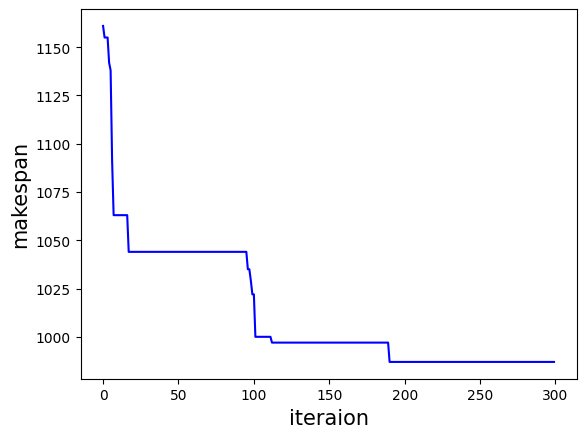

CPU times: user 11 s, sys: 51.7 ms, total: 11.1 s
Wall time: 10.9 s


In [33]:
%%time

best_gene_history: list = []

# Genetic_Algorithm 
for iter in tqdm(range(num_iteration)):
    # generate offspring by crossover
    parent_list, offspring_list = crossover(population_list=population_list, crossover_rate=crossover_rate)

    # offspring repairment
    offspring_list = repairmet(offspring_list)

    # offspring mutation
    offspring_list = mutation(offspring_list,mutation_rate = mutation_rate, num_mutation_jobs = num_mutation_jobs)

    # all chromosome：parent and offspring
    total_chromosome = parent_list.copy() + offspring_list.copy()

    # calculate fitness for each chromosome
    # chrom_fit, chrom_fitness, total_fitness, = fitness_caculate(total_chromosome)
    chrom_fit, chrom_fitness, total_fitness = fitness_caculate(total_chromosome)

    # select the new population
    population_list = selection(chrom_fitness, total_fitness, population_list)

    # comparision 
    Tbest_current, sequence_current = comparsion(chrom_fit, total_chromosome)
    # 將目前這代population中最好的染色體，與迭代過程中最好的比較
    # 現在の世代の集団で最も優れた染色体を、反復プロセスで最も優れた染色体と比較します。
    if Tbest_current <= Tbest:
        Tbest = Tbest_current
        sequence_best = sequence_current.copy()
        best_gene_history.append(sequence_best)

    makespan_record.append(Tbest)
    

"""----------result----------"""
# Genetic_Algorithm()
print("optimal solution",sequence_best)
print("optimal makespan:",Tbest)


plt.plot([i for i in range(len(makespan_record))],makespan_record,"b")
plt.ylabel("makespan", fontsize=15)
plt.xlabel("iteraion", fontsize=15)
plt.show()


In [34]:
len(sequence_best), len(best_gene_history[-1]), sequence_best == best_gene_history[-1]

(100, 100, True)

In [35]:
np.array(total_chromosome).shape

(200, 100)

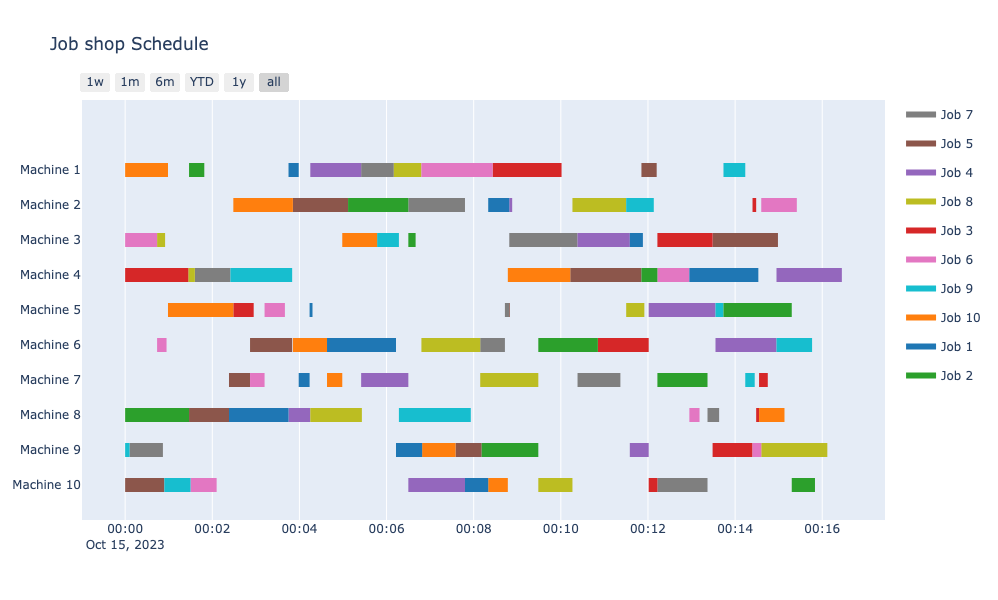

In [36]:
def prepare_gannt_data_from(
    m_keys: list[int], j_keys: list[int], sequence_best: list[int]
) -> dict:
    key_count = {key: 0 for key in j_keys}
    j_count = {key: 0 for key in j_keys}
    m_count = {key: 0 for key in m_keys}
    j_record = {}
    
    for i in sequence_best:
        gen_t: int = int(pt[i][key_count[i]])
        gen_m: int = int(ms[i][key_count[i]])
        j_count[i] = j_count[i] + gen_t
        m_count[gen_m] = m_count[gen_m] + gen_t
        
        if m_count[gen_m] < j_count[i]:
            m_count[gen_m] = j_count[i]
        elif m_count[gen_m] > j_count[i]:
            j_count[i] = m_count[gen_m]
    
        # convert seconds to hours, minutes and seconds
        start_time: str = str(datetime.timedelta(seconds=j_count[i] - pt[i][key_count[i]]))
        end_time: str = str(datetime.timedelta(seconds=j_count[i]))
            
        j_record[(i, gen_m)] = [start_time, end_time]
        
        key_count[i] = key_count[i] + 1

    return j_record


def format_gannt_data(m_keys: list[int], j_keys: list[int], j_record):
    frame_dicts = []
    for m in m_keys:
        for j in j_keys:
            frame_dicts.append(dict(
                Task="Machine %s"%(m),
                Start="2023-10-15 %s"%(str(j_record[(j, m)][0])),
                Finish="2023-10-15 %s"%(str(j_record[(j, m)][1])),
                Resource="Job %s"%(j+1))
            )
            # df.append(dict(Task="Machine %s"%(m), Start="2018-07-14 %s"%(str(j_record[(j,m)][0])), Finish="2018-07-14 %s"%(str(j_record[(j,m)][1])),Resource="Job %s"%(j+1)))
    return frame_dicts


m_keys = [j + 1 for j in range(num_machine)]
j_keys = [j for j in range(num_job)]
j_record: dict = prepare_gannt_data_from(m_keys, j_keys, sequence_best)

frame_dicts: list[dict] = format_gannt_data(m_keys, j_keys, j_record)
fig = ff.create_gantt(
    frame_dicts, index_col="Resource",
    show_colorbar=True, group_tasks=True, showgrid_x=True, title="Job shop Schedule"
)
# iplot(fig, filename="GA_job_shop_scheduling")
fig

In [129]:
# initial_gene = best_gene_history[0]

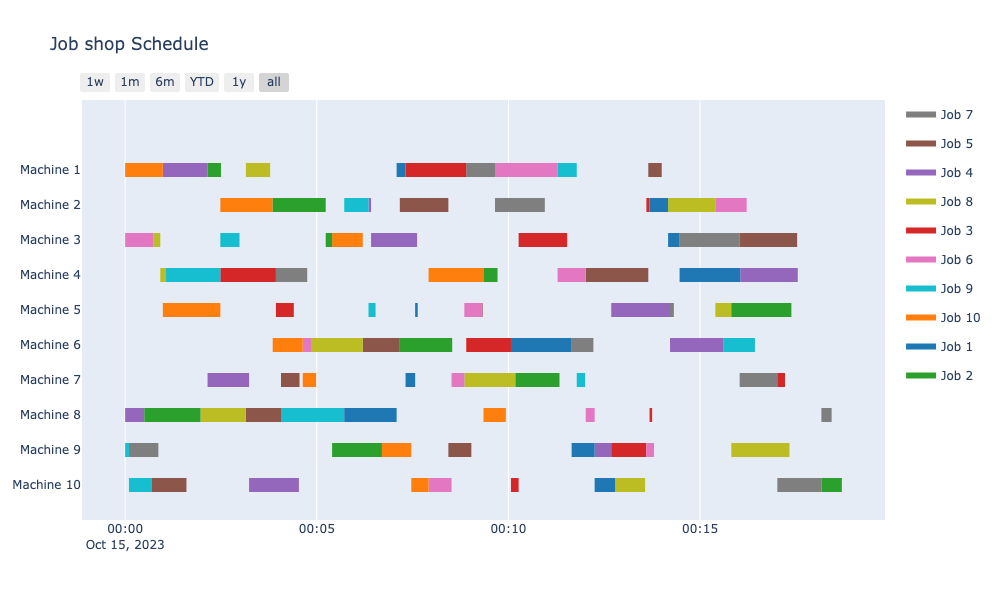

In [29]:
j_record_: dict = prepare_gannt_data_from(m_keys, j_keys, best_gene_history[2])

frame_dicts_: list[dict] = format_gannt_data(m_keys, j_keys, j_record_)
fig_ = ff.create_gantt(
    frame_dicts_, index_col="Resource",
    show_colorbar=True, group_tasks=True, showgrid_x=True, title="Job shop Schedule"
)
fig_

In [142]:
first_gannt_plot = fig.data[0]
# first_gannt_plot